Task1: separating unforgettable examples and forgettable examples in 60000 train examples

In [ ]:
epochs=10

In [ ]:
from __future__ import print_function
import argparse
import numpy as np
import numpy.random as npr
import time
import os
import sys
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms


# Format time for printing purposes
def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s


# Setup basic CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))


        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# Train model for one epoch
#
# example_stats: dictionary containing statistics accumulated over every presentation of example
#
def train(model, device, trainset, optimizer, epoch, example_stats):
    train_loss = 0
    correct = 0
    total = 0
    batch_size = 64

    model.train()

    # Get permutation to shuffle trainset
    trainset_permutation_inds = npr.permutation(
        np.arange(len(trainset.labels_train)))

    for batch_idx, batch_start_ind in enumerate(
            range(0, len(trainset.labels_train), batch_size)):

        # Get trainset indices for batch
        batch_inds = trainset_permutation_inds[batch_start_ind:
                                               batch_start_ind + batch_size]

        # Get batch inputs and targets, transform them appropriately
        transformed_trainset = []
        for ind in batch_inds:
            transformed_trainset.append(trainset.__getitem__(ind)[0])
        inputs = torch.stack(transformed_trainset)
        targets = torch.LongTensor(
            np.array(trainset.labels_train)[batch_inds].tolist())

        # Map to available device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward propagation, compute loss, get predictions
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        _, predicted = torch.max(outputs.data, 1)

        # Update statistics and loss
        acc = predicted == targets
        for j, index in enumerate(batch_inds):

            # Get index in original dataset (not sorted by forgetting)
            index_in_original_dataset = train_indx[index]

            # Compute missclassification margin
            output_correct_class = outputs.data[
                j, targets[j].item()]  # output for correct class
            sorted_output, _ = torch.sort(outputs.data[j, :])
            if acc[j]:
                # Example classified correctly, highest incorrect class is 2nd largest output
                output_highest_incorrect_class = sorted_output[-2]
            else:
                # Example misclassified, highest incorrect class is max output
                output_highest_incorrect_class = sorted_output[-1]
            margin = output_correct_class.item(
            ) - output_highest_incorrect_class.item()

            # Add the statistics of the current training example to dictionary
            index_stats = example_stats.get(index_in_original_dataset,
                                            [[], [], []])
            index_stats[0].append(loss[j].item())
            index_stats[1].append(acc[j].sum().item())
            index_stats[2].append(margin)
            example_stats[index_in_original_dataset] = index_stats

        # Update loss, backward propagate, update optimizer
        loss = loss.mean()
        train_loss += loss.item()
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        loss.backward()
        optimizer.step()

        sys.stdout.write('\r')
        sys.stdout.write(
            '| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%' %
            (epoch, epochs, batch_idx + 1,
             (len(trainset) // batch_size) + 1, loss.item(),
             100. * correct.item() / total))
        sys.stdout.flush()

        # Add training accuracy to dict
        index_stats = example_stats.get('train', [[], []])
        index_stats[1].append(100. * correct.item() / float(total))
        example_stats['train'] = index_stats


# Evaluate model predictions on heldout test data
#
# example_stats: dictionary containing statistics accumulated over every presentation of example
#
def test(model, device, testset, example_stats):
    test_loss = 0
    correct = 0
    total = 0
    test_batch_size = 32

    model.eval()

    for batch_idx, batch_start_ind in enumerate(
            range(0, len(testset.test_labels), test_batch_size)):

        # Get batch inputs and targets
        transformed_testset = []
        for ind in range(
                batch_start_ind,
                min(
                    len(testset.test_labels),
                    batch_start_ind + test_batch_size)):
            transformed_testset.append(testset.__getitem__(ind)[0])
        inputs = torch.stack(transformed_testset)
        targets = torch.LongTensor(
            np.array(testset.test_labels)[batch_start_ind:batch_start_ind +
                                          test_batch_size].tolist())

        # Map to available device
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward propagation, compute loss, get predictions
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss = loss.mean()
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Add test accuracy to dict
    acc = 100. * correct.item() / total
    index_stats = example_stats.get('test', [[], []])
    index_stats[1].append(100. * correct.item() / float(total))
    example_stats['test'] = index_stats
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %
          (epoch, loss.item(), acc))

In [ ]:
# Set appropriate devices
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True}

# Set random seed for initialization
torch.manual_seed(1)
torch.cuda.manual_seed(1)
npr.seed(1)


use b) to implement a novel approch by cutting out the middle square in each MNIST image, use a) otherwise

In [ ]:
# a) Setup transforms
all_transforms = [
    transforms.ToTensor(),
    transforms.Normalize((0.1307, ), (0.3081, ))
]

transform = transforms.Compose(all_transforms)

In [ ]:
# b) erase the middle square of each image in MNIST
# image_size=28
# def erase_middle(image: torch.Tensor) -> torch.Tensor:
#     for i in range(int(image_size/2-5),int(image_size/2+3)):
#         for j in range(int(image_size/2-5),int(image_size/2+3)):
#             image[:, i, j] = 0
#     return image

# erase bottom right: 
# x_start = width // 2 
# x_end = width // 2 + 8
# y_start = height // 2 
# y_end = height // 2 + 8 

# erase bottom left: 
# x_start = width // 2 - 8
# x_end = width // 2 
# y_start = height // 2 
# y_end = height // 2 + 8

# erase top right: 
# x_start = width // 2 
# x_end = width // 2 + 8
# y_start = height // 2 - 8 
# y_end = height // 2    

# erase top left: 
# x_start = width // 2 - 8
# x_end = width // 2 
# y_start = height // 2 - 8
# y_end = height // 2  

def erase_square(image: torch.Tensor) -> torch.Tensor:
    _, height, width = image.size()
    x_start = width // 2 - 8
    x_end = width // 2 
    y_start = height // 2 
    y_end = height // 2 + 8
    # Using slices achieves the same as the for loops
    image[:, y_start:y_end, x_start:x_end] = 0
    return image

transform = transforms.Compose(
    [
        # First transform it to a tensor
        transforms.ToTensor(),
        # Then erase the middle
        transforms.Lambda(erase_square),
    ]
)

In [ ]:
# Load the appropriate train and test datasets
trainset = datasets.MNIST(
    root='/tmp/data', train=True, download=True, transform=transform)
testset = datasets.MNIST(
    root='/tmp/data', train=False, download=True, transform=transform)

In [87]:
# a) normal
train_indx = np.array(range(len(trainset.train_labels)))

In [81]:
# b) exclude forgettable examples from train
train_indx = np.array(range(len(trainset.train_labels)))[unforget_lst]

In [88]:
# Reassign train data and labels
# trainset.train_data and .train_labels are attributes and cannot be set, hence using new ones instead
trainset.data_train = trainset.train_data[train_indx, :, :]
trainset.labels_train = np.array(trainset.train_labels)[train_indx].tolist()

In [89]:
len(trainset.labels_train)

60000

In [90]:
print('Training on ' + str(len(trainset.labels_train)) + ' examples')

Training on 60000 examples


In [91]:
# count unique values in the train labels list
from collections import Counter
count_dict = dict(Counter(trainset.labels_train))
count_dict


{5: 5421,
 0: 5923,
 4: 5842,
 1: 6742,
 9: 5949,
 2: 5958,
 3: 6131,
 6: 5918,
 7: 6265,
 8: 5851}

In [92]:
# Setup model and optimizer
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Setup loss
criterion = nn.CrossEntropyLoss()
criterion.__init__(reduce=False)

# Initialize dictionary to save statistics for every example presentation
example_stats = {}

elapsed_time = 0
for epoch in range(epochs):
    start_time = time.time()

    train(model, device, trainset, optimizer, epoch, example_stats)
    test(model, device, testset, example_stats)

    epoch_time = time.time() - start_time
    elapsed_time += epoch_time
    print('| Elapsed time : %d:%02d:%02d' % (get_hms(elapsed_time)))

    # Save the stats dictionary
    #fname = os.path.join(args.output_dir, save_fname)
    with open("__stats_dict_original_mnist.pkl", "wb") as f:
        pickle.dump(example_stats, f)

    # Log the best train and test accuracy so far
    with open("__best_acc_original_mnist.txt", "w") as f:
        f.write('train test \n')
        f.write(str(max(example_stats['train'][1])))
        f.write(' ')
        f.write(str(max(example_stats['test'][1])))

| Epoch [  0/ 10] Iter[938/938]		Loss: 0.1224 Acc@1: 87.368%
| Validation Epoch #0			Loss: 0.0555 Acc@1: 96.22%
| Elapsed time : 0:00:31
| Epoch [  1/ 10] Iter[938/938]		Loss: 0.1871 Acc@1: 96.428%
| Validation Epoch #1			Loss: 0.0088 Acc@1: 97.07%
| Elapsed time : 0:01:02
| Epoch [  2/ 10] Iter[938/938]		Loss: 0.1552 Acc@1: 97.418%
| Validation Epoch #2			Loss: 0.0044 Acc@1: 97.96%
| Elapsed time : 0:01:33
| Epoch [  3/ 10] Iter[938/938]		Loss: 0.0603 Acc@1: 97.843%
| Validation Epoch #3			Loss: 0.0015 Acc@1: 98.15%
| Elapsed time : 0:02:04
| Epoch [  4/ 10] Iter[938/938]		Loss: 0.2087 Acc@1: 98.275%
| Validation Epoch #4			Loss: 0.0006 Acc@1: 98.30%
| Elapsed time : 0:02:34
| Epoch [  5/ 10] Iter[938/938]		Loss: 0.1020 Acc@1: 98.488%
| Validation Epoch #5			Loss: 0.0006 Acc@1: 98.57%
| Elapsed time : 0:03:05
| Epoch [  6/ 10] Iter[938/938]		Loss: 0.0188 Acc@1: 98.677%
| Validation Epoch #6			Loss: 0.0003 Acc@1: 98.74%
| Elapsed time : 0:03:36
| Epoch [  7/ 10] Iter[938/938]		Loss: 0.

In [50]:
infile = open('/content/__stats_dict_original_mnist.pkl','rb')
forgetting_stats_dict = pickle.load(infile)

In [51]:
len(forgetting_stats_dict)

60002

In [52]:
# Calculates forgetting statistics per example
#
# diag_stats: dictionary created during training containing 
#             loss, accuracy, and missclassification margin 
#             per example presentation
# npresentations: number of training epochs
#
# Returns 4 dictionaries with statistics per example
#
def compute_forgetting_statistics(diag_stats, npresentations):

    presentations_needed_to_learn = {}
    unlearned_per_presentation = {}
    margins_per_presentation = {}
    first_learned = {}

    for example_id, example_stats in diag_stats.items():

        # Skip 'train' and 'test' keys of diag_stats
        if not isinstance(example_id, str):

            # Forgetting event is a transition in accuracy from 1 to 0
            presentation_acc = np.array(example_stats[1][:npresentations])
            transitions = presentation_acc[1:] - presentation_acc[:-1]

            # Find all presentations when forgetting occurs
            if len(np.where(transitions == -1)[0]) > 0:
                unlearned_per_presentation[example_id] = np.where(
                    transitions == -1)[0] + 2
            else:
                unlearned_per_presentation[example_id] = []

            # Find number of presentations needed to learn example, 
            # e.g. last presentation when acc is 0
            if len(np.where(presentation_acc == 0)[0]) > 0:
                presentations_needed_to_learn[example_id] = np.where(
                    presentation_acc == 0)[0][-1] + 1
            else:
                presentations_needed_to_learn[example_id] = 0

            # Find the misclassication margin for each presentation of the example
            margins_per_presentation = np.array(
                example_stats[2][:npresentations])

            # Find the presentation at which the example was first learned, 
            # e.g. first presentation when acc is 1
            if len(np.where(presentation_acc == 1)[0]) > 0:
                first_learned[example_id] = np.where(
                    presentation_acc == 1)[0][0]
            else:
                first_learned[example_id] = np.nan

    return presentations_needed_to_learn, unlearned_per_presentation, margins_per_presentation, first_learned

# Sorts examples by number of forgetting counts during training, in ascending order
# If an example was never learned, it is assigned the maximum number of forgetting counts
# If multiple training runs used, sort examples by the sum of their forgetting counts over all runs
#
# unlearned_per_presentation_all: list of dictionaries, one per training run
# first_learned_all: list of dictionaries, one per training run
# npresentations: number of training epochs
#
# Returns 2 numpy arrays containing the sorted example ids and corresponding forgetting counts
#
def sort_examples_by_forgetting(unlearned_per_presentation_all,
                                first_learned_all, npresentations):

    # Initialize lists
    example_original_order = []
    example_stats = []

    for example_id in unlearned_per_presentation_all[0].keys():

        # Add current example to lists
        example_original_order.append(example_id)
        example_stats.append(0)

        # Iterate over all training runs to calculate the total forgetting count for current example
        for i in range(len(unlearned_per_presentation_all)):

            # Get all presentations when current example was forgotten during current training run
            stats = unlearned_per_presentation_all[i][example_id]

            # If example was never learned during current training run, add max forgetting counts
            if np.isnan(first_learned_all[i][example_id]):
                example_stats[-1] += npresentations
            else:
                example_stats[-1] += len(stats)

    print('Number of unforgettable examples: {}'.format(
        len(np.where(np.array(example_stats) == 0)[0])))
    return np.array(example_original_order)[np.argsort(
        example_stats)], np.sort(example_stats)

In [53]:
# Initialize lists to collect forgetting stastics per example across multiple training runs
unlearned_per_presentation_all, first_learned_all = [], []
# Compute the forgetting statistics per example for training run
_, unlearned_per_presentation, _, first_learned = compute_forgetting_statistics(
    forgetting_stats_dict, epochs)

unlearned_per_presentation_all.append(
    unlearned_per_presentation)
first_learned_all.append(first_learned)

In [54]:
# Sort examples by forgetting counts in ascending order, over one or more training runs
ordered_examples, ordered_values = sort_examples_by_forgetting(
    unlearned_per_presentation_all, first_learned_all, epochs)

Number of unforgettable examples: 57941


In [55]:
len(ordered_values)

60000

In [ ]:
#ordered_examples

array([15281,  6717,   403, ..., 43014,  4334, 25546])

In [56]:
import pandas as pd
dataset = pd.DataFrame({'example_id': ordered_examples, 'forgetting_counts': list(ordered_values)}, columns=['example_id', 'forgetting_counts'])

In [ ]:
dataset

,example_id,forgetting_counts
0,15281,0
1,11833,0
2,33180,0
3,3706,0
4,55204,0
...,...,...
59995,20350,10
59996,59719,10
59997,41614,10
59998,2901,10


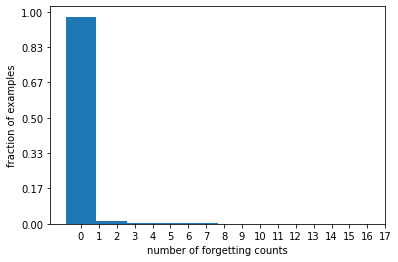

In [ ]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax1.hist(ordered_values, align='left')
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:.2f}'.format(x / 60000) for x in y_vals])
plt.xticks(range(0,18))
plt.xlabel('number of forgetting counts')
plt.ylabel('fraction of examples')
plt.show()

In [ ]:
dataset['forgetting_counts'].value_counts()

0     57467
1      1148
2       504
3       307
4       210
5       123
6        89
7        57
8        48
9        16
10       14
11       12
12        2
14        2
17        1
Name: forgetting_counts, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

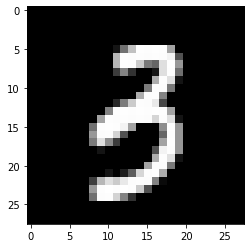

In [ ]:
# show images with specific index from MNIST
x, _ = trainset[15281] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

In [57]:
# saving unforgettable examples according to their class
from collections import defaultdict
Examples_unforget = defaultdict(list)

for i in dataset[dataset.forgetting_counts==0].example_id:
  Examples_unforget[trainset.labels_train[i]].append(i)

In [58]:
# saving forgettable examples according to their class
Examples_forget = defaultdict(list)

for i in dataset[dataset.forgetting_counts!=0].example_id:
  Examples_forget[trainset.labels_train[i]].append(i)

In [ ]:
with open('examples_unforget_mnist.txt', 'w') as f:
    print(Examples_unforget, file=f)

In [ ]:
with open('examples_forget_mnist.txt', 'w') as f:
    print(Examples_forget, file=f)

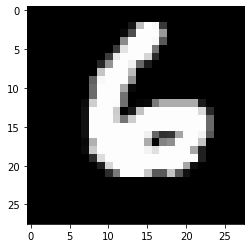

In [ ]:
index=Examples_unforget.get(6)[100]
x, _ = trainset[index] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

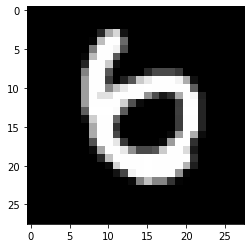

In [ ]:
index=Examples_forget.get(6)[100]
x, _ = trainset[index] # x is now a torch.Tensor
plt.imshow(x.numpy()[0], cmap='gray')

In [59]:
for key in Examples_unforget.keys():
  print(key, len(Examples_unforget.get(key)))

3 5911
0 5810
2 5725
6 5785
5 5243
1 6623
9 5630
4 5631
8 5535
7 6048


In [60]:
# get indice of unforgettable examples
unforget_lst=dataset[dataset.forgetting_counts==0].example_id.tolist()
len(unforget_lst)

57941

In [61]:
# get indice of forgettable examples
forget_lst=dataset[dataset.forgetting_counts!=0].example_id.tolist()
len(forget_lst)

2059

In [ ]:
type(dataset[dataset.forgetting_counts!=0].example_id)

pandas.core.series.Series